C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [17:16:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH1.csv
Mean Squared Error (MSE): 0.007001603294497516
Mean Absolute Error (MAE): 0.024322053476968055
R-squared (R²): 0.9529618010373186


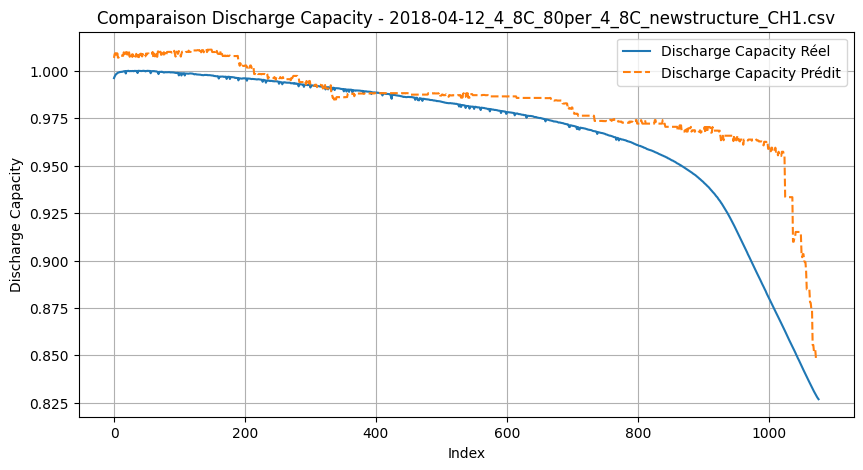

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH17.csv
Mean Squared Error (MSE): 0.004250774436293489
Mean Absolute Error (MAE): 0.01926203100168868
R-squared (R²): 0.9710236125344617


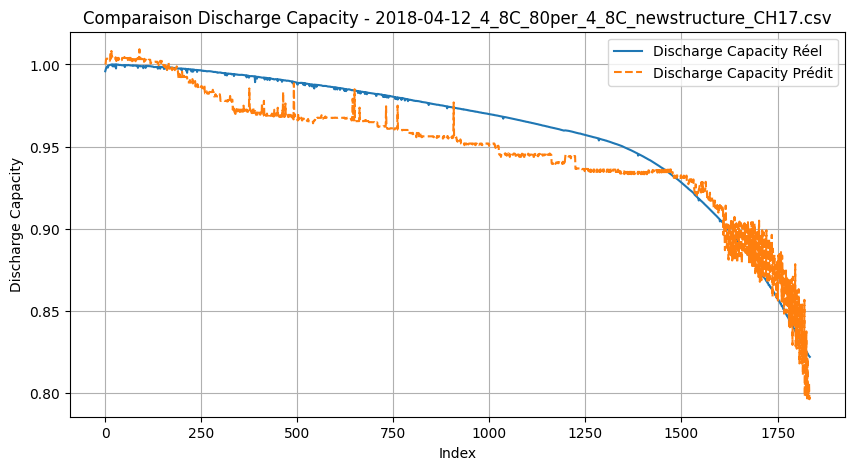

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH25.csv
Mean Squared Error (MSE): 0.007521384335040067
Mean Absolute Error (MAE): 0.030406619186072587
R-squared (R²): 0.9470079564023033


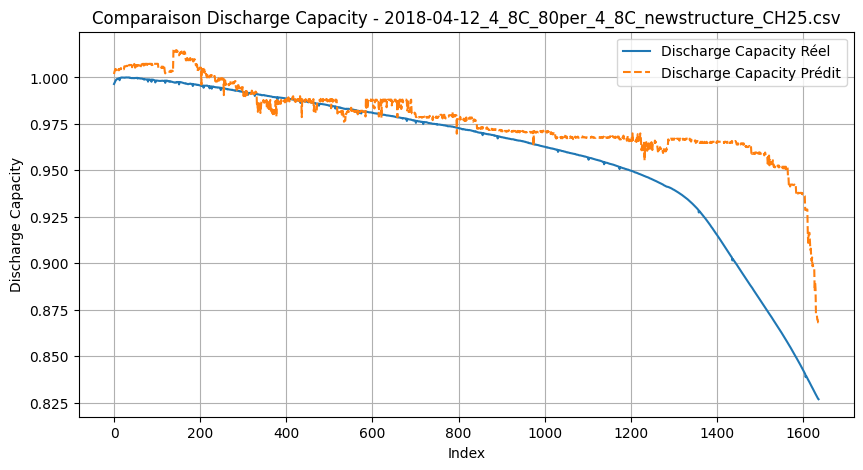

Fichier de test: 2018-04-12_4_8C_80per_4_8C_newstructure_CH9.csv
Mean Squared Error (MSE): 0.00591736628144999
Mean Absolute Error (MAE): 0.022988601616893086
R-squared (R²): 0.9583616807269708


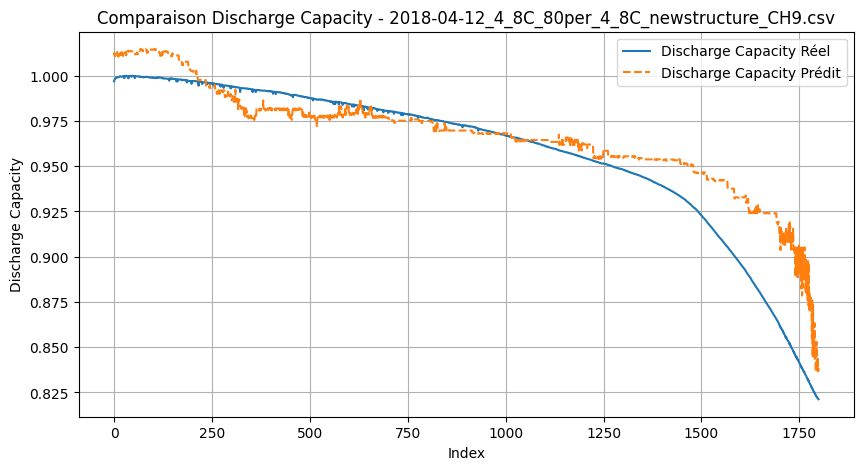

In [13]:
import os
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]   # Les 5 derniers fichiers pour le test

# Initialiser les ensembles de données d'entraînement
X_train_total = []
y_train_total = []

# Préparer les données d'entraînement
for csv_file in train_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X = df.drop(columns=['Discharge_Capacity'])
    y = df['Discharge_Capacity']
    X_train_total.append(X)
    y_train_total.append(y)

# Concaténer les données d'entraînement
X_train = pd.concat(X_train_total, axis=0)
y_train = pd.concat(y_train_total, axis=0)

# Convertir en matrices DMatrix de XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Définir les paramètres du modèle
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'alpha': 10,
    'n_estimators': 100
}

# Entraîner le modèle
model_xgb = xgb.train(params, dtrain, num_boost_round=100)
model_path='C:\\Users\\pc\\Desktop\\PHM-BATTERIES\\Models\\xgb.json'
model_xgb.save_model(model_path)
# Tester le modèle sur chaque fichier de test
for csv_file in test_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X_test = df.drop(columns=['Discharge_Capacity'])
    y_test = df['Discharge_Capacity']
    
    # Convertir en matrice DMatrix de XGBoost
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Faire des prédictions
    xgb_pred = model_xgb.predict(dtest)
    
    # Limiter les prédictions entre 0.8 et 1
    #xgb_pred = np.clip(xgb_pred, 0.8, 1)
    
    # Convertir y_test en DataFrame pour aligner les indices
    y_test_df = pd.DataFrame(y_test).reset_index(drop=True)

    # Calculer les métriques
    mse = mean_squared_error(y_test_df, xgb_pred)
    mae = mean_absolute_error(y_test_df, xgb_pred)
    r2 = r2_score(y_test_df, xgb_pred)

    # Afficher les résultats
    print(f"Fichier de test: {csv_file}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")
    
    cycle_index = df['Cycle_Index']
    
    xgb_pred_max_per_cycle = pd.Series(xgb_pred).groupby(cycle_index).max()
    y_test_max_per_cycle = y_test.groupby(cycle_index).max()
    
    # Tracer le graphique pour comparer les valeurs réelles et prédites
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_max_per_cycle, label='Discharge Capacity Réel')
    plt.plot(xgb_pred_max_per_cycle, label='Discharge Capacity Prédit', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Discharge Capacity')
    plt.title(f'Comparaison Discharge Capacity - {csv_file}')
    plt.legend()
    plt.grid(True)
    plt.show()


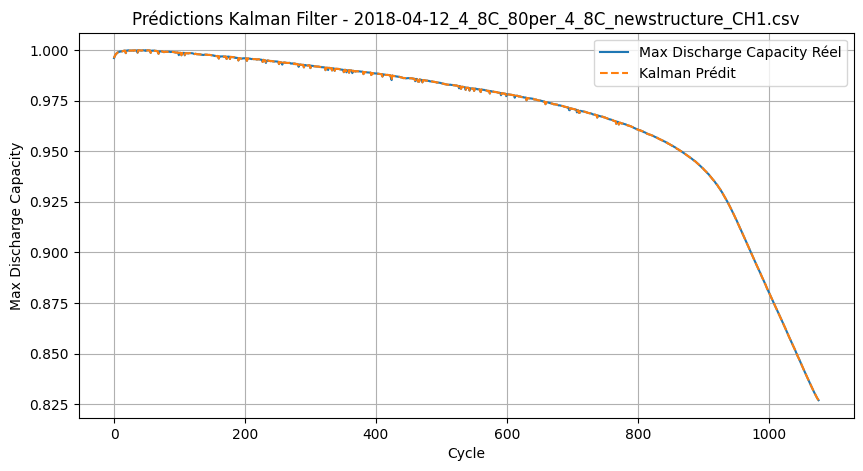

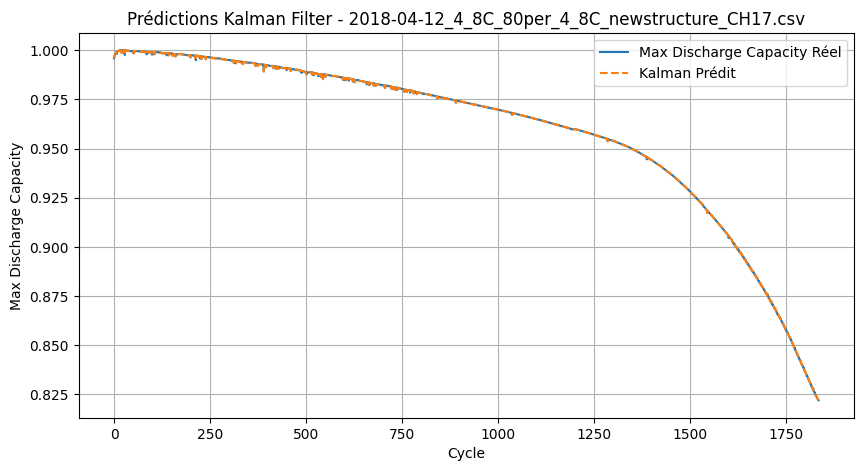

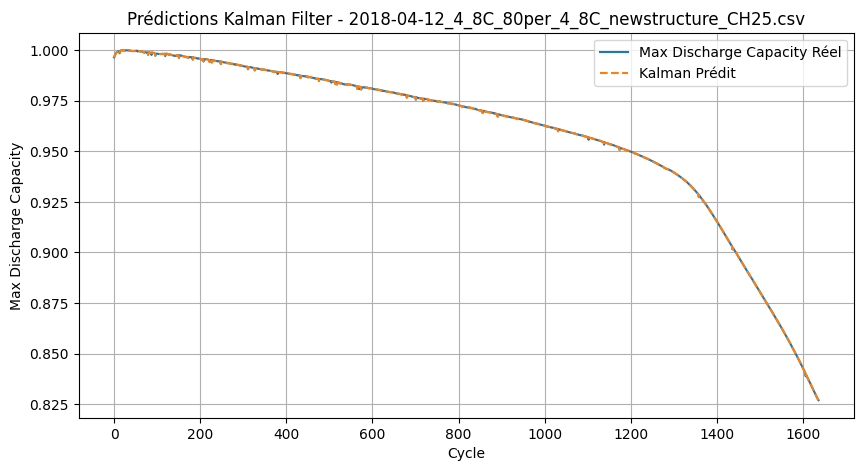

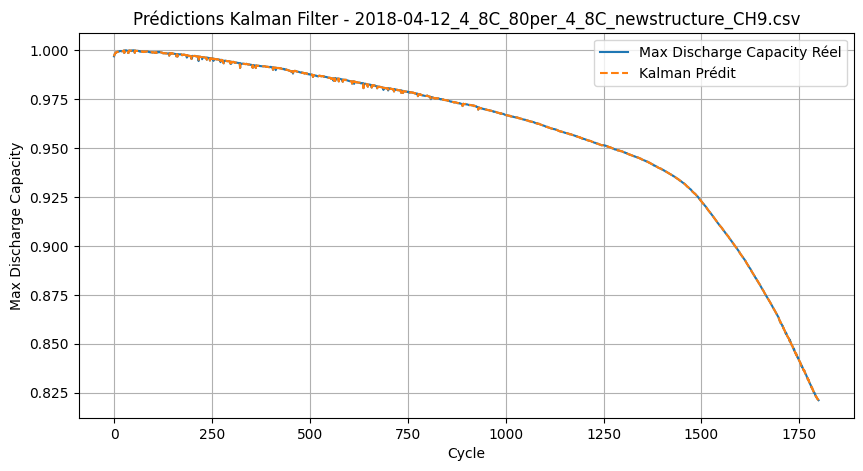

MSE moyen pour le modèle de Kalman: 0.00015077747151010537


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]   # Les 5 derniers fichiers pour le test

# Fonction pour entraîner un filtre de Kalman sur les données de capacité de décharge
def train_kalman_filter(train_data):
    # Initialiser le filtre de Kalman avec des paramètres simplifiés
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    
    # Réduire le nombre d'itérations d'EM pour accélérer l'entraînement
    kf = kf.em(train_data, n_iter=5)  # Réduire à 5 itérations d'EM
    return kf

# Entraîner le filtre de Kalman sur les fichiers d'entraînement
y_train_total = []

for csv_file in train_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    y_train = df['Discharge_Capacity']
    y_train_total.append(y_train)

# Concaténer les données d'entraînement
y_train = pd.concat(y_train_total, axis=0).values

# Réduire le nombre de données d'entraînement si nécessaire
if len(y_train) > 10000:
    y_train = y_train[::10]  # Sous-échantillonner les données pour accélérer l'entraînement

# Entraîner le filtre de Kalman sur les données de capacité de décharge
kf = train_kalman_filter(y_train.reshape(-1, 1))

# Tester le modèle de Kalman sur les fichiers de test
mse_list = []
for csv_file in test_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    y_test = df['Discharge_Capacity'].values
    cycle_index = df['Cycle_Index']

    # Utiliser le filtre de Kalman pour faire des prédictions
    kalman_pred, _ = kf.filter(y_test.reshape(-1, 1))

    # Calculer le MSE entre les vraies valeurs et les prédictions
    mse = mean_squared_error(y_test, kalman_pred)
    mse_list.append(mse)

    # Calculer le max discharge capacity par cycle
    y_test_max_per_cycle = df.groupby('Cycle_Index')['Discharge_Capacity'].max()
    kalman_pred_max_per_cycle = pd.Series(kalman_pred.flatten()).groupby(cycle_index).max()

    # Afficher les graphes pour chaque fichier
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_max_per_cycle.values, label='Max Discharge Capacity Réel')
    plt.plot(kalman_pred_max_per_cycle.values, label='Kalman Prédit', linestyle='--')
    plt.xlabel('Cycle')
    plt.ylabel('Max Discharge Capacity')
    plt.title(f'Prédictions Kalman Filter - {csv_file}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Afficher le MSE moyen sur les fichiers de test
print(f"MSE moyen pour le modèle de Kalman: {np.mean(mse_list)}")


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Fonction pour créer des fenêtres temporelles
def create_sequences(X, y, time_steps=5):  # Augmentation des time_steps à 5
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]   # Les fichiers restants pour le test

# Initialiser les ensembles de données d'entraînement
X_train_total = []
y_train_total = []
scaler = MinMaxScaler(feature_range=(0, 1))

# Préparer les données d'entraînement
for csv_file in tqdm(train_files, desc="Préparation des données d'entraînement"):
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    
    # Normalisation des données
    df_scaled = scaler.fit_transform(df.drop(columns=['Discharge_Capacity']))
    X = df_scaled
    y = df['Discharge_Capacity'].values
    
    X_train_total.append(X)
    y_train_total.append(y)

# Concaténer les données d'entraînement
X_train = np.concatenate(X_train_total, axis=0)
y_train = np.concatenate(y_train_total, axis=0)

# Créer des séquences avec time_steps = 5
time_steps = 5  # Augmentation des time_steps
X_train, y_train = create_sequences(X_train, y_train, time_steps)

# Créer et entraîner le modèle LSTM avec des couches supplémentaires et du Dropout
model = Sequential()
model.add(LSTM(150, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout pour éviter le surapprentissage
model.add(LSTM(100, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')  # Diminution du learning rate

# Entraîner le modèle avec plus d'époques
history = model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)  # Augmentation des époques à 50

# Tester le modèle sur chaque fichier de test
for csv_file in tqdm(test_files, desc="Test du modèle"):
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    
    # Normalisation des données de test
    X_test_scaled = scaler.transform(df.drop(columns=['Discharge_Capacity']))
    y_test = df['Discharge_Capacity'].values
    
    # Créer des séquences de test
    X_test, y_test = create_sequences(X_test_scaled, y_test, time_steps)

    # Faire des prédictions
    lstm_pred = model.predict(X_test)
    
    # Limiter les prédictions entre 0 et 1
    lstm_pred = np.clip(lstm_pred, 0, 1).flatten()
    
    # Calculer les métriques
    mse = mean_squared_error(y_test, lstm_pred)
    mae = mean_absolute_error(y_test, lstm_pred)
    r2 = r2_score(y_test, lstm_pred)

    # Afficher les résultats
    print(f"Fichier de test: {csv_file}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")
    
    cycle_index = df['Cycle_Index']
    
    lstm_pred_max_per_cycle = pd.Series(lstm_pred).groupby(cycle_index[:len(lstm_pred)]).max()
    y_test_max_per_cycle = pd.Series(y_test).groupby(cycle_index[:len(y_test)]).max()
    
    # Tracer le graphique pour comparer les valeurs réelles et prédites
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_max_per_cycle, label='Discharge Capacity Réel')
    plt.plot(lstm_pred_max_per_cycle, label='Discharge Capacity Prédit', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Discharge Capacity')
    plt.title(f'Comparaison Discharge Capacity - {csv_file}')
    plt.legend()
    plt.grid(True)
    plt.show()


Préparation des données d'entraînement: 100%|██████████| 12/12 [00:25<00:00,  2.15s/it]
C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


Mean Squared Error (MSE): 0.09082827871286815
Mean Absolute Error (MAE): 0.1503474902500281
R-squared (R²): 0.38979709848865585

Mean Squared Error (MSE): 0.13791142363019016
Mean Absolute Error (MAE): 0.19231014237026756
R-squared (R²): 0.059894871646752335

Mean Squared Error (MSE): 0.12994960492305627
Mean Absolute Error (MAE): 0.18818444547241195
R-squared (R²): 0.08443780787737465

Mean Squared Error (MSE): 0.1307117820523424
Mean Absolute Error (MAE): 0.18658181286645945
R-squared (R²): 0.08022950499045689

In [16]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Chemin vers le répertoire contenant les fichiers CSV
data_path = r'C:\\Users\\pc\\Desktop\\data\\all batchs'

# Lister tous les fichiers CSV dans le répertoire donné
csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# Sélectionner les fichiers pour l'entraînement et le test
train_files = csv_files[:12]  # Les 12 premiers fichiers pour l'entraînement
test_files = csv_files[12:]   # Les fichiers restants pour le test

# Initialiser les ensembles de données d'entraînement
X_train_total = []
y_train_total = []

# Préparer les données d'entraînement
for csv_file in train_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X = df.drop(columns=['Discharge_Capacity'])
    y = df['Discharge_Capacity']
    X_train_total.append(X)
    y_train_total.append(y)

# Concaténer les données d'entraînement
X_train = pd.concat(X_train_total, axis=0)
y_train = pd.concat(y_train_total, axis=0)

# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Optimisation des hyperparamètres avec GridSearchCV
param_grid = {
    'alpha_1': [1e-6, 1e-5, 1e-4],
    'alpha_2': [1e-6, 1e-5, 1e-4],
    'lambda_1': [1e-6, 1e-5, 1e-4],
    'lambda_2': [1e-6, 1e-5, 1e-4]
}

grid_search = GridSearchCV(BayesianRidge(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
bayesian_model = grid_search.best_estimator_

# Validation croisée
cv_scores = cross_val_score(bayesian_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated MSE: {-cv_scores.mean()}")

# Préparer les données de test
X_test_total = []
y_test_total = []

for csv_file in test_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    X_test = df.drop(columns=['Discharge_Capacity'])
    y_test = df['Discharge_Capacity']
    X_test_total.append(X_test)
    y_test_total.append(y_test)

X_test = pd.concat(X_test_total, axis=0)
y_test = pd.concat(y_test_total, axis=0)

# Normaliser les données de test
X_test_scaled = scaler.transform(X_test)

# Faire des prédictions
y_pred = bayesian_model.predict(X_test_scaled)

# Limiter les prédictions entre 0 et 1 (ajuster selon tes besoins)
#y_pred = np.clip(y_pred, 0.8, 1)

# Calculer les métriques
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# Tester et afficher les résultats pour chaque fichier de test
for csv_file in test_files:
    file_path = os.path.join(data_path, csv_file)
    df = pd.read_csv(file_path)
    cycle_index = df['Cycle_Index']
    
    y_test = df['Discharge_Capacity']
    y_test_max_per_cycle = y_test.groupby(cycle_index).max()
    y_pred_max_per_cycle = pd.Series(y_pred).groupby(cycle_index).max()
    
    # Tracer le graphique pour comparer les valeurs réelles et prédites
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_max_per_cycle, label='Discharge Capacity Réel')
    plt.plot(y_pred_max_per_cycle, label='Discharge Capacity Prédit', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Discharge Capacity')
    plt.title(f'Comparaison Discharge Capacity - {csv_file}')
    plt.legend()
    plt.grid(True)
    plt.show()


KeyboardInterrupt: 